In [4]:
# !pip install transformers
# !wget https://raw.githubusercontent.com/stkao05/eng-eval/main/train.csv

In [61]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

## Data Exploration

In [8]:
train_df = pd.read_csv("train.csv")
train_df.head(5)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [9]:
len(train_df)

3911

In [10]:
print(train_df.full_text[0])

I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.

The hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.

most students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go take a

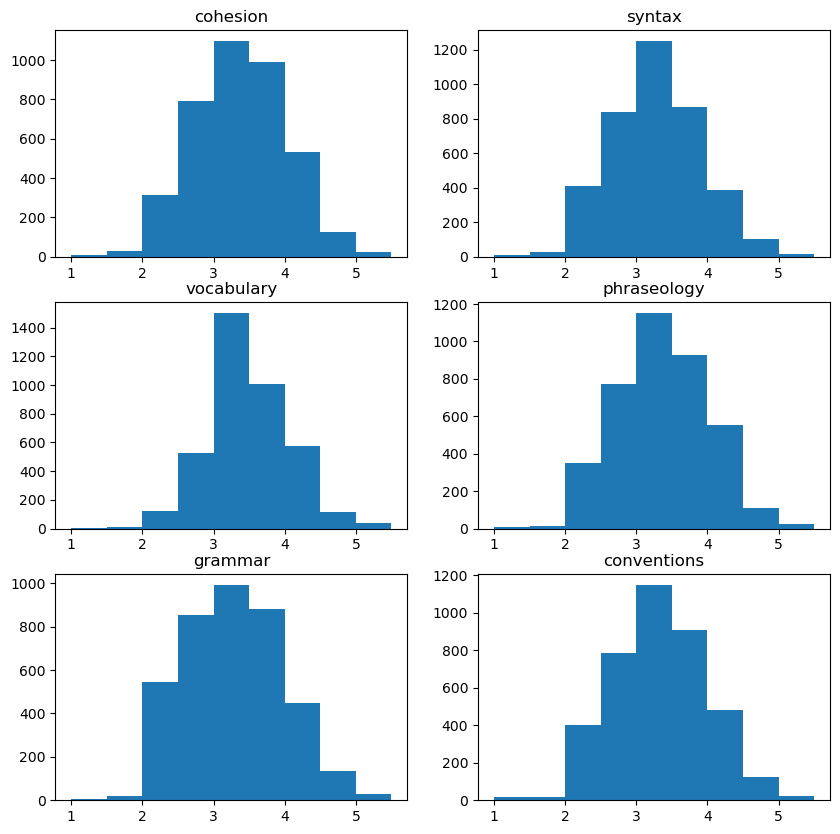

In [12]:
def visualize_dist(df):
    fig, axs = plt.subplots(3, 2)
    fig.set_size_inches(10, 10)
    bins = torch.arange(1, 6, 0.5)

    axs[0, 0].hist(df.cohesion.values, bins=bins);
    axs[0, 0].set_title('cohesion')
    axs[0, 1].hist(df.syntax.values, bins=bins);
    axs[0, 1].set_title('syntax')
    axs[1, 0].hist(df.vocabulary.values, bins=bins);
    axs[1, 0].set_title('vocabulary')
    axs[1, 1].hist(df.phraseology, bins=bins);
    axs[1, 1].set_title('phraseology')
    axs[2, 0].hist(df.grammar, bins=bins);
    axs[2, 0].set_title('grammar')
    axs[2, 1].hist(df.conventions, bins=bins);
    axs[2, 1].set_title('conventions')
    
visualize_dist(train_df)

In [13]:
train_df.loc[train_df['grammar'] == 1].head(5)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
514,2716F5E20A4F,"The students be required to take music ,drama ...",1.5,1.0,1.5,1.0,1.0,1.5
952,48EA282A4EAF,some student offer distance learning as an opt...,1.0,1.0,1.0,1.0,1.0,1.0
1528,75A20F93C2C4,i like to work with a group a cash if you work...,1.5,1.5,1.5,1.0,1.0,1.0
1540,767533E12569,he is a good because they are the prescient an...,1.0,1.0,1.0,1.0,1.0,1.0
1554,776FBF88E6FF,Welll its going to be ah good beefit but in th...,1.5,1.5,2.0,2.0,1.0,1.0


In [16]:
print(train_df.full_text[1540])

he is a good because they are the prescient and us. now the are more procession a other prescient and us. because and the more many education for student and school. the more school for one because he have a one women the have many education for a other because the good more the one is information for access because is not like the brazen giant of Greek fame with conquering one nation for is the imprison the eyes command the one book for people the us give more your lied your huddled Farmer with silent lips the more the one is for you because the are a one solution for you and a other people he have a more the one solution for you here ancient lands your storied pound Aries she with silent lips pledge of a in order people he have a education

Do we accomplish more the if we are always doing something or does inactivity also serve a purpose take a position on this for you and specific examples. take a position for you because the are a never much may be a always how many I planned and m

In [17]:
train_df.corr(numeric_only=True)

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
cohesion,1.000000,0.695459,0.666151,0.690058,0.638689,0.666151
syntax,0.695459,1.000000,0.680562,0.725467,0.709525,0.700025
vocabulary,0.666151,0.680562,1.000000,0.735261,0.654852,0.664292
phraseology,0.690058,0.725467,0.735261,1.000000,0.719746,0.666842
grammar,0.638689,0.709525,0.654852,0.719746,1.000000,0.673301
conventions,0.666151,0.700025,0.664292,0.666842,0.673301,1.000000


## Processing Feature 

In [78]:
z = train_df["grammar"]
z = torch.tensor(z).view(-1, 1)
scaler = StandardScaler().fit(z)
scaler.transform([[1], [2], [3], [4], [5]])

array([[-2.9051126 ],
       [-1.47603325],
       [-0.0469539 ],
       [ 1.38212545],
       [ 2.8112048 ]])

In [83]:
train_df["grammar_std"] = train_df["grammar"].apply(lambda x:scaler.transform([[x]])[0][0])

In [84]:
train_df.head(5)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,grammar_std
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,1.382125
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,-1.476033
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,-0.046954
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,1.382125
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,-0.761494


In [85]:
train, valid = train_test_split(train_df, test_size=0.1, shuffle=True)

splits = {
 "train": train,
 "valid": valid,
}

len(train), len(valid)

(3519, 392)

# Tokenizer

In [86]:
from transformers import BertModel
from transformers import BertTokenizer

tz = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")
bert_embed = bert.embeddings.word_embeddings

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [87]:
t = '''I like school.

just kidding.'''
enc = tz(t)
enc

{'input_ids': [101, 1045, 2066, 2082, 1012, 2074, 12489, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [88]:
tz.convert_ids_to_tokens(enc["input_ids"])

['[CLS]', 'i', 'like', 'school', '.', 'just', 'kidding', '.', '[SEP]']

We can see that the tokenizer would:
- Remove newline
- Add [CLS] and [SEP] to beginning and end of text

In the context of this model where we are evaluating an essay, we don't need special tokens as they are mostly used for generative model (?)

In [89]:
t = '''I like school.

Hello world.'''
enc = tz(t, add_special_tokens=False)
tz.convert_ids_to_tokens(enc["input_ids"])

['i', 'like', 'school', '.', 'hello', 'world', '.']

In [90]:
x = ["i like school", "hello"] 
tz(x, add_special_tokens=False, padding="longest")

{'input_ids': [[1045, 2066, 2082], [7592, 0, 0]], 'token_type_ids': [[0, 0, 0], [0, 0, 0]], 'attention_mask': [[1, 1, 1], [1, 0, 0]]}

In [91]:
df = splits["train"]
serie = df.full_text.iloc[0:5]
txt = list(serie)
enc = tz(txt, add_special_tokens=False, padding="longest", return_tensors="pt")
enc

Token indices sequence length is longer than the specified maximum sequence length for this model (924 > 512). Running this sequence through the model will result in indexing errors


{'input_ids': tensor([[1045, 5993, 2138,  ...,    0,    0,    0],
        [2028, 2095, 3283,  ..., 2000, 2817, 1012],
        [2748, 1010, 1045,  ...,    0,    0,    0],
        [3112, 2003, 2055,  ...,    0,    0,    0],
        [1045, 2052, 2066,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [93]:
class DataFrameIterator:
    def __init__(self, df, batch_size):
        self.df = df
        self.batch_size = batch_size
        
    def __iter__(self):
        self.start = 0
        return self
    
    def __len__(self):
        last = 0 if len(self.df) % self.batch_size == 0 else 1
        return (len(self.df) // self.batch_size) + last
    
    # x: (B, L) - contains interger, representing vocab index
    # y: (L) - a list of integer, grammar score
    def __next__(self):
        if self.start >= len(self.df):
            raise StopIteration()
        
        end = self.start + self.batch_size
        txt = list(self.df.full_text.iloc[self.start:end])
        enc = tz(txt, 
                 add_special_tokens=False,
                 return_tensors="pt",
                 max_length=256,
                 padding="max_length",
                 truncation=True)
        
        x = enc["input_ids"].to(device)
        y = torch.tensor(list(self.df.grammar_std.iloc[self.start:end]), device=device, dtype=torch.float64)
        self.start = end
        return x, y    
    
itr = iter(DataFrameIterator(splits["train"], 32))
x, y = next(itr)
x.shape, y.shape

(torch.Size([32, 256]), torch.Size([32]))

In [95]:
y

tensor([ 0.6676,  0.6676, -0.7615, -1.4760, -0.0470, -0.7615,  0.6676, -0.0470,
        -0.0470, -1.4760, -0.0470,  0.6676,  0.6676, -0.0470, -0.0470, -0.0470,
         1.3821, -0.7615, -0.7615,  1.3821,  0.6676, -0.7615, -0.7615, -0.0470,
        -0.7615, -0.0470, -0.7615,  0.6676, -1.4760,  2.0967, -1.4760,  0.6676],
       dtype=torch.float64)

## Model

In [96]:
y = torch.tensor([ 1.0, 2.0, 3.0, 4.0])
yh = torch.tensor([1.0, 2.1, 4.0, 6.0])

def bound_accuracy(y, yh, bound=0.5):
    dif = (y - yh).abs()
    acc = (dif <= bound).float().mean()
    return acc

bound_accuracy(y, yh, 0.5)

tensor(0.5000)

In [97]:
class LSTM(nn.Module):
    
    def __init__(self, emb, hidden_size):
        super().__init__()
        vocab_size, embed_size = emb.weight.shape
        self.hidden_size = hidden_size
        
        self.emb = nn.Embedding.from_pretrained(emb.weight).double()
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True, dtype=torch.float64)
        self.linear = nn.Linear(hidden_size, 1, dtype=torch.float64)
        
    def forward(self, x):
        B, _, = x.shape
        emb = self.emb(x) # (B, L, emb)        
        seq, (hidden, _) = self.lstm(emb) # (1, B, hidden)
        hidden = hidden.view(B, self.hidden_size) # (B, hidden)
        y = self.linear(hidden) # (B, 1)
        y = y.view(B)  # (B)
        y = y.double()
        
        return y

In [98]:
itr = iter(DataFrameIterator(splits["train"], 32))
model = LSTM(bert_embed, hidden_size=512)
model = model.to(device)

In [99]:
x, y = next(itr)
yh = model(x)
yh

tensor([-0.0410, -0.0347, -0.0366, -0.0354, -0.0344, -0.0289, -0.0413, -0.0410,
        -0.0295, -0.0358, -0.0335, -0.0424, -0.0391, -0.0348, -0.0351, -0.0396,
        -0.0338, -0.0302, -0.0256, -0.0362, -0.0340, -0.0343, -0.0402, -0.0411,
        -0.0288, -0.0379, -0.0410, -0.0399, -0.0321, -0.0406, -0.0410, -0.0295],
       dtype=torch.float64, grad_fn=<ViewBackward0>)

In [100]:
@torch.no_grad()
def eval_split(model, split, sample_size=None):
    model.eval()
    df = splits[split]
    
    if sample_size:
        idx = torch.randint(0, len(df), size=(sample_size,))
        df = df.iloc[idx]
        
    itr = DataFrameIterator(df, batch_size=32)
    
    yi = []
    yhi = []
    lossi = [] 

    for xb, yb in itr:
        yh = model(xb)
        loss = F.mse_loss(yb, yh, reduction="mean")
        lossi.append(loss.item())
        yi += yb
        yhi += yh

    yi = torch.tensor(yi)
    yhi = torch.tensor(yhi)    
    loss = np.mean(lossi)
    acc = bound_accuracy(yi, yhi, 0.5)
    
    model.train()
    return np.mean(lossi), acc

In [58]:
gra_mean = train_df['grammar'].mean()

def baseline_model(x):
    B, L = x.shape
    y = torch.tensor(gra_mean, device=device)
    return y.repeat(B)

baseline_model.eval = lambda :None
baseline_model.train = lambda :None

In [76]:
eval_split(baseline_model, "valid")

(0.48893674697778766, tensor(0.4847))

In [102]:
model = LSTM(bert_embed, hidden_size=1026)
model = model.to(device)
opti = optim.Adam(model.parameters())
sum(p.numel() for p in model.parameters() if p.requires_grad)

7371811

In [103]:
eval_split(model, "valid")

(0.9959578353497202, tensor(0.2857))

In [60]:
model.train()

df = splits["train"]
itr = DataFrameIterator(df, batch_size=64)

epoch = 10
metric = []
i = 0
n = len(itr) * epoch

for _ in range(epoch):
    for _, (xb, yb) in enumerate(itr):
        yh = model(xb)
        loss = F.mse_loss(yb, yh, reduction="mean")
        opti.zero_grad()
        loss.backward()
        opti.step()
        
        print(loss)
        break
        
        
        if i % 10 == 0:
            tr_loss = loss.item()
            tr_acc = bound_accuracy(yb, yh, 0.5)
            va_loss, va_acc = eval_split(model, "valid", 64)
            metric.append([tr_loss, tr_acc.item(), va_loss.item(), va_acc.item()])
            print(f"[{i+1:2d}/{n}]: {tr_loss:.4f} {va_loss:.4f} {tr_acc:.4f}")
            
        i += 1
        
    break

tensor(9.0524, dtype=torch.float64, grad_fn=<MseLossBackward0>)


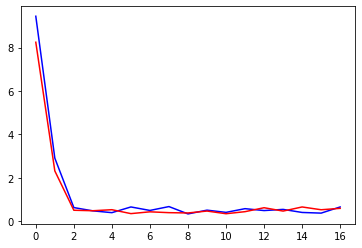

In [127]:
tr_loss = [tr for tr, _, _, _ in metric]
va_loss = [va for _, _, va, _ in metric]

plt.plot(tr_loss, "b")
plt.plot(va_loss, "r")

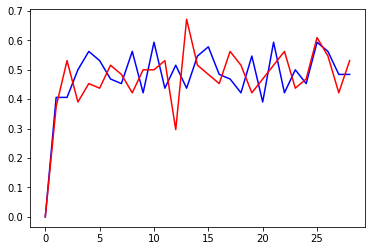

In [121]:
tr_acc = [tr for _, tr, _, _ in metric]
va_acc = [va for _, _, _, va in metric]

plt.plot(tr_acc, "b")
plt.plot(va_acc, "r")

In [122]:
eval_split(model, "valid")

(0.48436483937989927, tensor(0.4872))

## Transformer

In [ ]:
@dataclass
class Config:
    vocab_size: int
    block_size: int
    emb_size: int
    head_num: int
    head_size: int
    layer_num: int
    ctoi: dict
    dropout: float


class MultiHeadAttension(nn.Module):

    def __init__(self, c: Config):
        super().__init__()
        assert c.emb_size / c.head_size == c.head_num

        self.head_size = c.head_size
        self.head_num = c.head_num
        self.attn = nn.Linear(
            c.emb_size, 3 * c.head_num * c.head_size, bias=False)
        self.ffn = nn.Linear(c.head_num * c.head_size, c.emb_size, bias=False)

        self.attn_dropout = nn.Dropout(c.dropout)
        self.resid_dropout = nn.Dropout(c.dropout)

    # x: (B, L, C)
    # return: (B, L, C)
    def forward(self, x):
        B, L, C = x.shape

        z = self.attn(x)  # (B, L, 3 * hn * hs)
        k, q, v = torch.split(
            z, self.head_num * self.head_size, dim=2)  # (B, L, hn * hs)

        k = k.view(B, L, self.head_num, self.head_size).permute(
            0, 2, 1, 3)  # (B, hn, L, hs)
        q = q.view(B, L, self.head_num, self.head_size).permute(0, 2, 1, 3)
        v = v.view(B, L, self.head_num, self.head_size).permute(0, 2, 1, 3)

        q = q.permute(0, 1, 3, 2)  # (B, hn, hs, L)
        attn = (k @ q) / self.head_size**0.5  # (B, hn, L, L)
        mask = torch.tril(torch.ones(L, L)) == 0
        mask = mask.to(x.device)
        attn = attn.masked_fill(mask, -float('inf'))  # (B, hn, L, L)
        attn = F.softmax(attn, dim=3)
        attn = self.attn_dropout(attn)

        y = attn @ v  # (B, hn, L, hs)
        y = y.permute(0, 2, 1, 3)  # (B, L, hn, hs)
        y = y.contiguous().view(B, L, -1)  # (B, L, hn * hs)
        y = self.ffn(y)  # (B, L, C)
        y = self.resid_dropout(y)

        return y


class FeedForward(nn.Module):

    def __init__(self, c: Config):
        super().__init__()
        self.linear1 = nn.Linear(c.emb_size, 2 * c.emb_size)
        self.linear2 = nn.Linear(2 * c.emb_size, c.emb_size)
        self.dropout = nn.Dropout(c.dropout)

    # (B, L, C)
    def forward(self, x):
        y = self.linear1(x)
        y = torch.relu(y)
        y = self.linear2(y)
        y = self.dropout(y)

        return y


class Block(nn.Module):

    def __init__(self, c: Config):
        super().__init__()

        assert c.emb_size % c.head_size == 0
        assert c.emb_size / c.head_size == c.head_num

        self.mha = MultiHeadAttension(c)
        self.lnorm1 = nn.LayerNorm(c.emb_size)
        self.lnorm2 = nn.LayerNorm(c.emb_size)
        self.ffn = FeedForward(c)

    # x: (B, L, emb)
    def forward(self, x):
        y = self.mha(x) + x
        y = self.lnorm1(y)
        y = self.ffn(y) + y
        y = self.lnorm2(y)
        return y


class Transformer(nn.Module):

    def __init__(self, c: Config, embed):
        super().__init__()
        self.config = c
        self.embed = embed
        self.dropout = nn.Dropout(c.dropout)
        self.blocks = nn.Sequential(
            *[Block(c) for _ in range(c.layer_num)]
        )
        self.proj = nn.Linear(c.emb_size, c.vocab_size)

    # return (L, C)
    def pos_encoding(self, x):
        B, L, C = x.shape
        pos = torch.arange(0, L).view(-1, 1)  # (L, 1)
        div = 2 * torch.arange(0, C) / C  # (C)
        div = torch.pow(10000, div)  # (C)
        e = pos / div
        pe = torch.zeros(L, C)
        pe[:, 0::2] = torch.sin(e[:, 0::2])
        pe[:, 1::2] = torch.cos(e[:, 1::2])

        pe = pe.to(x.device)
        return pe

    # (B, L) -> (B, L, C)
    def forward(self, x):        
        y = self.embed(x)  # (B, L, emb)
        y = y + self.pos_encoding(y)  # (B, L, emb)
        y = self.dropout(y)
        y = self.blocks(y)  # (B, L, emb)
        y = self.proj(y)  # (B, L, vocab)

        return y

    @torch.no_grad()
    def sample(self, max_len):
        device = next(self.parameters()).device
    
        self.eval()
        itoc = {i: c for c, i in self.config.ctoi.items()}
        tks = [0] * self.config.block_size

        for i in range(max_len):
            ctx = torch.tensor(tks[i:i+self.config.block_size], device=device)  # (L)
            ctx = ctx.view(1, -1)  # (B, L)

            logits = self.forward(ctx)  # (B, L, C)
            probs = F.softmax(logits, dim=2)  # (B, L, C)
            # (C), # the last in the sequence is the newly generated
            probs = probs[0, -1, :]
            yi = torch.multinomial(probs, 1)
            tks.append(yi.item())

        tks = tks[self.config.block_size:]
        chars = [itoc.get(t, "_") for t in tks]
        self.train()
        return "".join(chars)

In [ ]:
bert_embed.weight.shape

In [ ]:
vocab_size, emb_size = bert_embed.weight.shape
config = Config(
    vocab_size=vocab_size,
    emb_size=emb_size,
    block_size=256,
    head_num=12,
    head_size=64,
    layer_num=2,
    ctoi=tokenizer.vocab,
    dropout=0
)

tf_model = Transformer(config, bert_embed)

In [ ]:
tf_model.sample(10)

# Log
validation performan, (loss, 0.5 bounded accuracy)

- Baseline: 0.4882, 0.4917
- LSTM, before training: 9.9371, 0
- LSTM, single data, 900 run: 0.5717, 0.4840


In [ ]:
(0.8046356645914224, tensor(0.4056)